In [1]:
import re

import numpy as np
import pandas as pd

import folium
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_crime = pd.read_csv('/home/aberforth/Downloads/ny-2010-2016-school-safety-report/2010-2016-school-safety-report.csv')

In [3]:
df_year = df_crime.groupby(['School Year'])

In [4]:
df_year_dict = {}
for item in df_year:
    df_year_dict[item[0]] = item[1]

In [5]:
x, feq = np.unique(df_year_dict['2014-15']['DBN'], return_counts=True)
repeating_dbn = list(x[feq>1])

In [6]:
df_schools = pd.read_csv('/home/aberforth/kaggle/passnyc_data_science_for_good/input/2016 School Explorer.csv')

In [7]:
for col in df_schools.columns.values:
    if col.startswith("Percent") or col.endswith("%") or col.endswith("Rate"):
        df_schools[col] = df_schools[col].astype(np.object).str.replace('%', '').astype(float)

In [8]:
df_schools = df_schools[df_schools['Grade High'] != '0K']
df_schools = df_schools[df_schools['Grade High'].astype(int) > 5]
len(df_schools[df_schools['Grade High'].astype(int) > 5])

626

In [9]:
df_schools.dropna(subset=['Rigorous Instruction %',
'Collaborative Teachers %',
'Supportive Environment %',
'Effective School Leadership %',
'Strong Family-Community Ties %',
'Trust %'], inplace = True)

In [10]:
features = ['Rigorous Instruction %','Supportive Environment %','Effective School Leadership %',
            'Strong Family-Community Ties %']
weights = [0.8, 1, 0.7, 0.5]

df_schools['SPI'] = df_schools[features].dot(weights)

df_schools[features+['SPI']].head(5)

,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,SPI
3,85.0,82.0,73.0,89.0,245.6
8,94.0,85.0,87.0,83.0,262.6
10,90.0,91.0,67.0,83.0,251.4
11,100.0,99.0,99.0,92.0,294.3
12,72.0,77.0,72.0,76.0,223.0


In [11]:
intersection = set(df_crime['DBN']).intersection(set(df_schools['Location Code']))

In [12]:
for dbn in list(x[feq>1]):
    print df_schools[df_schools['Location Code'] == dbn]['School Name']
    print df_year_dict['2014-15'][df_year_dict['2014-15']['DBN'] == dbn]['Location Name']
    print

149    COLUMBIA SECONDARY SCHOOL
Name: School Name, dtype: object
2988                Columbia Secondary School
2989    KIPP STAR College Prep Charter School
Name: Location Name, dtype: object

637    I.S. 364 GATEWAY
Name: School Name, dtype: object
2628    I.S. 364 Gateway
2819    IS 364 ANNEX(BN)
Name: Location Name, dtype: object

Series([], Name: School Name, dtype: object)
3724             P25 ANNEX ARTHUR KILL ROAD(SI)
3725    South Richmond High School I.S./P.S. 25
Name: Location Name, dtype: object



In [13]:
len(intersection)

541

In [14]:
df_crime.columns.values

array(['School Year', 'Building Code', 'DBN', 'Location Name',
       'Location Code', 'Address', 'Borough',
       'Geographical District Code', 'Register', 'Building Name',
       '# Schools', 'Schools in Building', 'Major N', 'Oth N', 'NoCrim N',
       'Prop N', 'Vio N', 'ENGroupA', 'RangeA', 'AvgOfMajor N',
       'AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N',
       'Borough Name', 'Postcode', 'Latitude', 'Longitude',
       'Community Board', 'Council District ', 'Census Tract', 'BIN',
       'BBL', 'NTA'], dtype=object)

<b> The data given spans over 3 school years -- 2013-14, 2014-15, 2015-16 <br>
<b> Adding the crime rates over 3 years for each school

In [15]:
crimes_col = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N']
crimes = df_crime.groupby(['DBN'], as_index=False)[crimes_col].sum()

<b> Merging the data for crimes with original school data to gain more insights

In [16]:
merged_df = pd.merge(crimes, df_schools, how='inner', left_on=['DBN'], right_on=['Location Code'])
print len(merged_df)

541


<b>Histograms to visualize the number of crimes across various schools

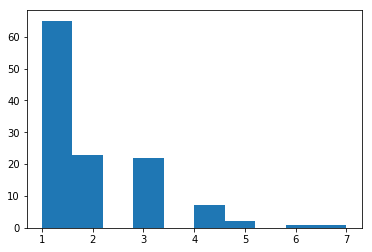

In [17]:
plt.figure()
ignore_nan = merged_df.dropna(subset=['Major N'])
plt.hist(ignore_nan['Major N'][ignore_nan['Major N']!=0])
plt.show()

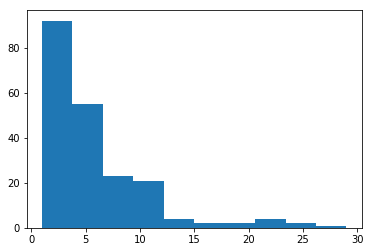

In [18]:
plt.figure()
ignore_nan = merged_df.dropna(subset=['Oth N'])
plt.hist(ignore_nan['Oth N'][ignore_nan['Oth N']!=0])
plt.show()

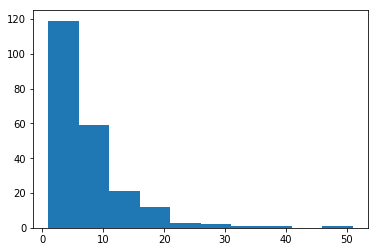

In [19]:
plt.figure()
ignore_nan = merged_df.dropna(subset=['NoCrim N'])
plt.hist(ignore_nan['NoCrim N'][ignore_nan['NoCrim N']!=0])
plt.show()

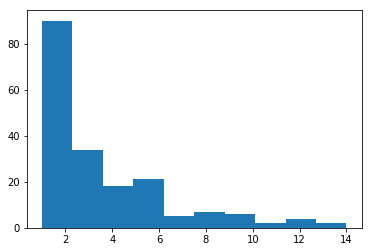

In [20]:
plt.figure()
ignore_nan = merged_df.dropna(subset=['Prop N'])
plt.hist(ignore_nan['Prop N'][ignore_nan['Prop N']!=0])
plt.show()

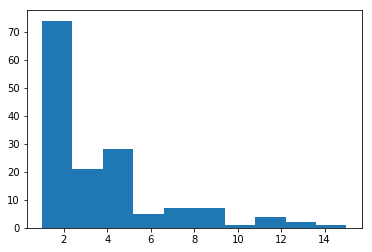

In [21]:
plt.figure()
ignore_nan = merged_df.dropna(subset=['Vio N'])
# violent_df = ignore_nan['Vio N'][ignore_nan['Vio N']!=0]
plt.hist(ignore_nan['Vio N'][ignore_nan['Vio N']!=0])
plt.show()

<b> Defining the schools where violent crimes are high

In [22]:
violent_df = ignore_nan[ignore_nan['Vio N'] > 4]
print len(violent_df)

43


In [23]:
violent_schools = violent_df['DBN']

In [24]:
poor_schools_df = merged_df[merged_df['SPI'] < merged_df['SPI'].quantile(0.25)]
poor_schools = poor_schools_df['Location Code']

In [25]:
poor_intersect_violent = set(violent_schools).intersection(set(poor_schools))

In [26]:
len(poor_intersect_violent)

19

In [27]:
print ((violent_df['Economic Need Index']).astype(float)).corr(violent_df['SPI'])

0.2187918528192016


<b> Listing schools with high number of major crimes

In [28]:
ignore_nan = merged_df.dropna(subset=['Major N'])
major_crime_df = ignore_nan[ignore_nan['Major N'] > 2]
print len(major_crime_df)
major_crime_schools = major_crime_df['DBN']

33


In [29]:
poor_intersect_majorCrime = set(major_crime_schools).intersection(set(poor_schools))

In [30]:
len(poor_intersect_majorCrime)

16

<b> Check the correlation between numbers of differnt crimes

In [31]:
crimes[crimes_col].corr()

,Major N,Oth N,NoCrim N,Prop N,Vio N
Major N,1.000000,0.746759,0.682164,0.807288,0.772462
Oth N,0.746759,1.000000,0.869463,0.932849,0.890065
NoCrim N,0.682164,0.869463,1.000000,0.785599,0.800293
Prop N,0.807288,0.932849,0.785599,1.000000,0.744577
Vio N,0.772462,0.890065,0.800293,0.744577,1.000000


<b> As the features are highly correlated, we apply PCA to reduce the number of features

In [32]:
features_5 = merged_df[crimes_col].values

In [33]:
from sklearn.decomposition import PCA

school_crime_pca = PCA(n_components=1)
school_crime_pca.fit(features_5)
school_crime_pca_results = school_crime_pca.transform(features_5)

In [34]:
print school_crime_pca.explained_variance_ratio_

[0.88755962]


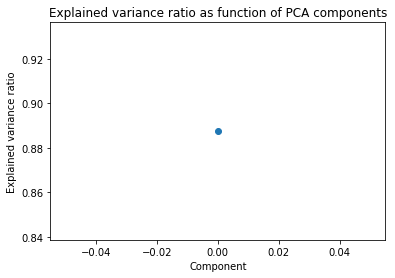

In [35]:
plt.plot(list(school_crime_pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Component')
plt.show()

In [36]:
school_crime_pca = PCA(n_components=1)
reduced_crime_features = school_crime_pca.fit_transform(features_5)

In [37]:
adjusted_reduced_crime_features = reduced_crime_features + abs(min(reduced_crime_features))

In [38]:
merged_df['SSI'] = adjusted_reduced_crime_features[:,0]

In [39]:
merged_df['SSI'].describe()

count    541.000000
mean       3.814301
std        7.189951
min        0.000000
25%        0.000000
50%        0.000000
75%        5.126890
max       53.650202
Name: SSI, dtype: float64

In [40]:
merged_df['SSI'].corr(merged_df['Prop N'])

0.8669424204723427

<b>Correlation of SSI with SPI, ENI and attendance

In [41]:
merged_df['SSI'].corr(merged_df['SPI'])

-0.24223232279896015

In [42]:
merged_df['SSI'].corr(merged_df['Economic Need Index'])

-0.008350580045569492

In [43]:
merged_df['SSI'].corr(merged_df['Percent of Students Chronically Absent'])

0.10948647954632297

In [44]:
merged_df['SSI'].corr(merged_df['Percent Black / Hispanic'])

-0.024115486754680296

<b> Schools with high SSI are marked as risky

In [45]:
risky_schools_df = merged_df[merged_df['SSI']>5]
risky_schools = risky_schools_df['DBN']

In [46]:
len(set(risky_schools).intersection(set(poor_schools)))

52

<b> Schools with high absentees

In [47]:
high_absent_df = merged_df[merged_df['Percent of Students Chronically Absent']>40]
high_absent = high_absent_df['DBN']

In [48]:
len(high_absent)

41

In [49]:
len(set(risky_schools).intersection(set(high_absent)))

16

<b> Correlation of SSI and SPI

In [50]:
merged_df['SSI'].corr(merged_df['SPI'])

-0.24223232279896015

In [51]:
merged_df['SSI'].corr(merged_df['Percent of Students Chronically Absent'])

0.10948647954632297

In [52]:
for col in crimes_col:
    print ((merged_df['Percent of Students Chronically Absent']).astype(int)).corr(merged_df[col])

0.08711123985517417
0.08635570392102343
0.11652050108442742
0.03062210157792802
0.1640728526230517


In [53]:
eni_non_nan = merged_df.dropna(subset = ['Economic Need Index'])

In [54]:
for col in crimes_col:
    print ((eni_non_nan['Economic Need Index']).astype(float)).corr(eni_non_nan[col])

-0.003948654210346705
-0.015285678897850027
-0.0034805977041548466
-0.05805057011701649
0.04722186359034848


In [55]:
for col in crimes_col:
    print ((merged_df['SPI']).astype(float)).corr(merged_df[col][merged_df[col]!=0])

-0.23185084028070127
-0.3579741141740324
-0.3999838341073044
-0.2931254645367997
-0.15914798747466033


In [56]:
for col in crimes_col:
    print ((merged_df['SPI']).astype(float)).corr(merged_df[col])

-0.12675354795440066
-0.22710582826942988
-0.24112727029139838
-0.18885752748757126
-0.21025586604180513
